### This note book has code to compare the distances / mutation rate derived from different sources

- Cen-hap flank distance vs. active array snp rate (mismatches / (matches + mismatches)) for closely aligned arrays (experiment with only showing points with an overall active array distance of less than X (say 0.2))

- Active array snp rate vs. short indel rate (short indel rate: # of indels less than 50bp / length of array).

- Active array snp rate vs. SV triangles rate (# of triangles / length of array) 

In [67]:
import pandas as pd
import glob
import os

In [68]:
### cenhap matrices filepaths

cenhap_matrices = ["/chr11/no_recombinants/HPRC_chr11_50650000_51023358_54476419_54808189_no_recomb_het449_m_final_dgp.m",
"/chr10/no_recombinants/HPRC_chr10_39415000_39633793_41926237_42547087_42982864_42995500_no_recomb_m_final_dgp.m",
"/chr12_prelim/HPRC_chr12_34544731_34593492_37202490_37285321_het60_m_hprc_dgp_rnj.m",
"/chr17_prelim/HPRC_chr17_23278614_23433372_27571319_27700000_het114_m_hprc_dgp.m",
"/chr4/no_recomb/HPRC_chr4_49185000_49705154_55303192_55475000_no_recomb_het449_m_final_dgp.m",
"/chr6_prelim/standard/HPRC_chr6_58200000_58286706_61058390_61123742_het70_m_hprc_dgp_rnj.m"]

cenhap_matrices = ["/private/groups/patenlab/mira/centrolign/annotations/hprc_cenhap_trees_12042025"+item for item in cenhap_matrices]

In [69]:
## This function reads in the cenhap distance matrices to a pandas dataframe 

def load_matrix(file):
    # Read all lines except first
    with open(file) as f:
        lines = f.readlines()[1:]

    data = []
    sample_names = []
    for line in lines:
        parts = line.strip().split()
        sample = parts[0]
        values = list(map(float, parts[1:]))
        data.append(values)
        sample_names.append(sample)

    # Create dataframe
    df = pd.DataFrame(data, index=sample_names, columns=sample_names)

    return df





def to_long_format(df):
    df.index.name = "sample1"

    long = df.stack().rename("cenhap_dist").reset_index()

    # The second column (index 1) is always the sample2 column
    long = long.rename(columns={long.columns[1]: "sample2"})

    return long



# -------------------------
# Main loop
# -------------------------

all_long = []  # <-- FIXED: create the correct list

for f in cenhap_matrices:
    mat = load_matrix(f)
    long = to_long_format(mat)
    long["source_file"] = f
    all_long.append(long)  # <-- FIXED: append to correct list

cenhap_dists = pd.concat(all_long, ignore_index=True)

# Add chromosome extracted from the filepath
cenhap_dists["chr"] = cenhap_dists["source_file"].str.extract(r"(chr[0-9XYM]+)")

print(cenhap_dists.head())


   sample1    sample2  cenhap_dist  \
0  CHM13.0    CHM13.0     0.000000   
1  CHM13.0  HG00097.1     0.002401   
2  CHM13.0  HG00097.2     0.002408   
3  CHM13.0  HG00099.1     0.002405   
4  CHM13.0  HG00126.1     0.002405   

                                         source_file    chr  
0  /private/groups/patenlab/mira/centrolign/annot...  chr11  
1  /private/groups/patenlab/mira/centrolign/annot...  chr11  
2  /private/groups/patenlab/mira/centrolign/annot...  chr11  
3  /private/groups/patenlab/mira/centrolign/annot...  chr11  
4  /private/groups/patenlab/mira/centrolign/annot...  chr11  


In [70]:
## Read in SNP distances
path = "/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/SNP_based_distances/"   # change to your directory

files = glob.glob(os.path.join(
    path,
    "*_r2_QC_v2_centrolign_pairwise_distance.csv"
))

dfs = []

for f in files:
    # extract chromosome name from filename
    base = os.path.basename(f)
    chr_name = base.split("_")[0]

    # read the tsv file (tab-separated)
    df = pd.read_csv(f, header=None, names=["sample1","sample2","snp_dist"])

    # add chr column
    df["chr"] = chr_name

    dfs.append(df)

# combine all files
snp_dist_df = pd.concat(dfs, ignore_index=True)
snp_dist_df.columns = ["sample1", "sample2", "snp_dist","chr"]
print(snp_dist_df)

           sample1    sample2  snp_dist   chr
0        HG03098.1  HG03784.1  0.007934  chr6
1        HG03098.1  NA20752.2  0.014866  chr6
2        HG01978.2  NA19835.1  0.006349  chr6
3        HG00741.1  NA18522.1  0.007092  chr6
4        HG00408.1  HG01496.1  0.001038  chr6
...            ...        ...       ...   ...
1132390  HG03471.2  NA18508.1  0.028102  chr5
1132391  HG02615.1  NA18948.1  0.020000  chr5
1132392  HG01891.1  NA19776.2  0.013699  chr5
1132393  HG00126.1  NA20827.1  0.000856  chr5
1132394  HG01150.2  HG01786.1  0.001502  chr5

[1132395 rows x 4 columns]


In [71]:
## Read in all pairs distance 

# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df = pd.read_csv(f, header=None,names=["sample1", "sample2", "direct_pairwise_dist","chr"])
    df["chr"] = chr_val
    all_dfs.append(df)

# Combine into one dataframe
all_pairs_dist_df = pd.concat(all_dfs, ignore_index=True)

all_pairs_dist_df.head()

,sample1,sample2,direct_pairwise_dist,chr
0,HG03098.1,HG03784.1,0.942968,chr6
1,HG03098.1,NA20752.2,0.974936,chr6
2,HG01978.2,NA19835.1,0.999883,chr6
3,HG00741.1,NA18522.1,0.999869,chr6
4,HG00408.1,HG01496.1,0.606856,chr6


In [72]:
# Merge the snp dist and cenhap dist data frames 

merged_df = pd.merge(
    cenhap_dists,
    snp_dist_df,
    on=["sample1", "sample2", "chr"],
    how="left"   # or "inner" if you only want matching rows
)

# now merge in the all pairs distances
merged_df = pd.merge(
    merged_df,
    all_pairs_dist_df,
    on=["sample1", "sample2", "chr"],
    how="left"   # or "inner" if you only want matching rows
)

merged_df.head()

,sample1,sample2,cenhap_dist,source_file,chr,snp_dist,direct_pairwise_dist
0,CHM13.0,CHM13.0,0.000000,/private/groups/patenlab/mira/centrolign/annot...,chr11,NaN,NaN
1,CHM13.0,HG00097.1,0.002401,/private/groups/patenlab/mira/centrolign/annot...,chr11,0.095238,0.999993
2,CHM13.0,HG00097.2,0.002408,/private/groups/patenlab/mira/centrolign/annot...,chr11,0.095238,0.999994
3,CHM13.0,HG00099.1,0.002405,/private/groups/patenlab/mira/centrolign/annot...,chr11,0.095238,0.999996
4,CHM13.0,HG00126.1,0.002405,/private/groups/patenlab/mira/centrolign/annot...,chr11,0.095238,0.999996


In [73]:
# ----------------------------
# 1. Define the bins and labels
# ----------------------------
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]

# Add a new column for the bin
merged_df["dist_bin"] = pd.cut(merged_df["direct_pairwise_dist"], bins=bins, labels=bin_labels, include_lowest=True)


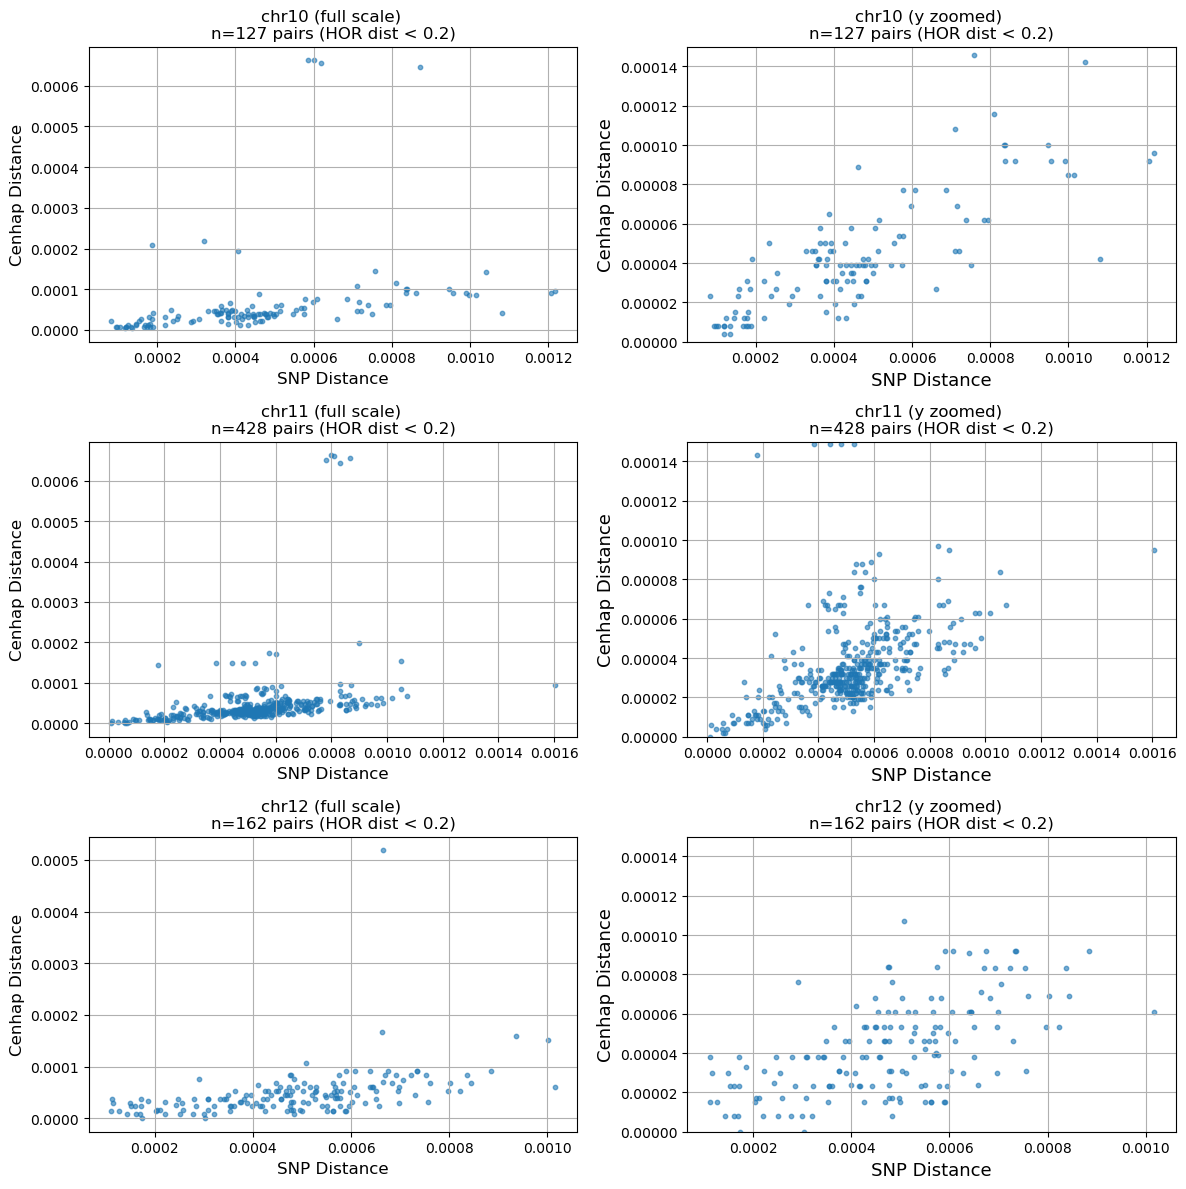

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Subset to specific chromosomes
selected_chrs = ["chr12", "chr11", "chr10"]
subset_df = merged_df[merged_df["chr"].isin(selected_chrs)]

# Filter only bin 0–0.2
bin_df = subset_df[subset_df["dist_bin"] == "0–0.2"]

# List of chromosomes
chromosomes = sorted(bin_df["chr"].unique())
n_chrs = len(chromosomes)

# Create figure: one row per chromosome, 2 columns per row
fig, axes = plt.subplots(nrows=n_chrs, ncols=2, figsize=(12, 4*n_chrs))

# Ensure axes is 2D (nrows x ncols) for consistent indexing
if n_chrs == 1:
    axes = axes.reshape(1, 2)
elif n_chrs > 1:
    axes = np.array(axes)

for i, chr_name in enumerate(chromosomes):
    chr_df = bin_df[bin_df["chr"] == chr_name]

    # Count unique samples
    n_pairs = len(chr_df)

    # Full scale plot
    ax_full = axes[i, 0]
    ax_full.scatter(chr_df["snp_dist"], chr_df["cenhap_dist"], alpha=0.6, s=10)
    ax_full.set_xlabel("SNP Distance",fontsize=12)
    ax_full.set_ylabel("Cenhap Distance",fontsize=12)
    ax_full.set_title(f"{chr_name} (full scale) \nn={n_pairs} pairs (HOR dist < 0.2)")
    ax_full.grid(True)

    # Zoomed y-axis plot
    ax_zoom = axes[i, 1]
    ax_zoom.scatter(chr_df["snp_dist"], chr_df["cenhap_dist"], alpha=0.6, s=10)
    ax_zoom.set_xlabel("SNP Distance",fontsize=13)
    ax_zoom.set_ylabel("Cenhap Distance",fontsize=13)
    ax_zoom.set_title(f"{chr_name} (y zoomed) \nn={n_pairs} pairs (HOR dist < 0.2)")
    ax_zoom.set_ylim(0, 0.00015)
    ax_zoom.grid(True)

plt.tight_layout()
plt.show()


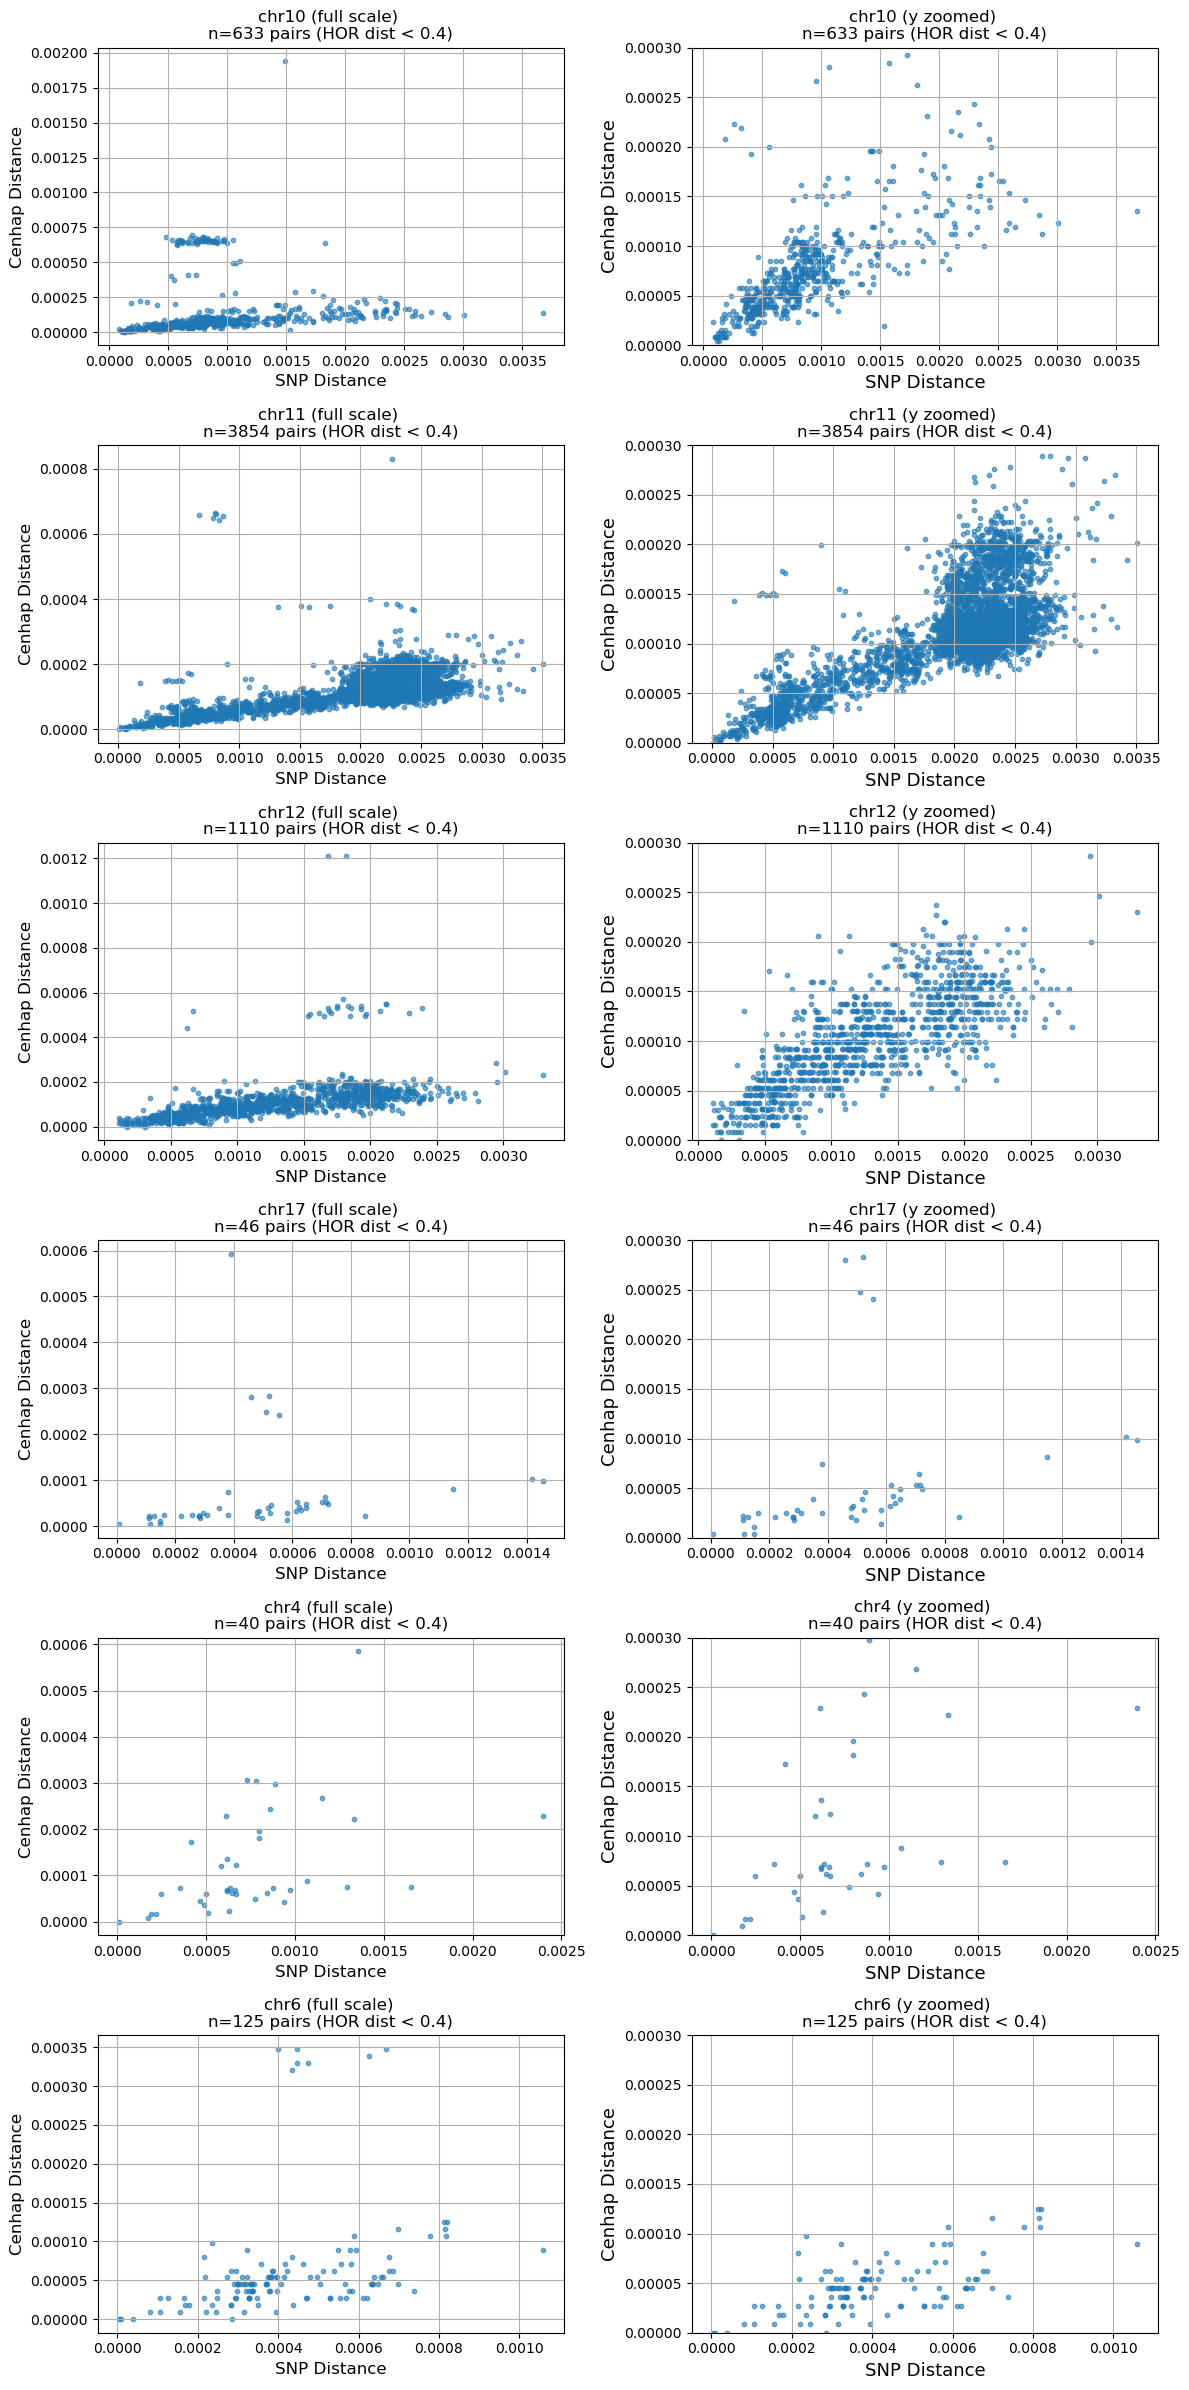

In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Subset to specific chromosomes
selected_chrs = ["chr12", "chr11", "chr10"]
subset_df = merged_df[merged_df["chr"].isin(selected_chrs)]

# Filter only bin 0–0.2
bin_df = merged_df[(merged_df["dist_bin"] == "0–0.2") | (merged_df["dist_bin"] == "0.2–0.4")]


# List of chromosomes
chromosomes = sorted(bin_df["chr"].unique())
n_chrs = len(chromosomes)

# Create figure: one row per chromosome, 2 columns per row
fig, axes = plt.subplots(nrows=n_chrs, ncols=2, figsize=(12, 4*n_chrs))

# Ensure axes is 2D (nrows x ncols) for consistent indexing
if n_chrs == 1:
    axes = axes.reshape(1, 2)
elif n_chrs > 1:
    axes = np.array(axes)

for i, chr_name in enumerate(chromosomes):
    chr_df = bin_df[bin_df["chr"] == chr_name]

    # Count unique samples
    n_pairs = len(chr_df)

    # Full scale plot
    ax_full = axes[i, 0]
    ax_full.scatter(chr_df["snp_dist"], chr_df["cenhap_dist"], alpha=0.6, s=10)
    ax_full.set_xlabel("SNP Distance",fontsize=12)
    ax_full.set_ylabel("Cenhap Distance",fontsize=12)
    ax_full.set_title(f"{chr_name} (full scale) \nn={n_pairs} pairs (HOR dist < 0.4)")
    ax_full.grid(True)

    # Zoomed y-axis plot
    ax_zoom = axes[i, 1]
    ax_zoom.scatter(chr_df["snp_dist"], chr_df["cenhap_dist"], alpha=0.6, s=10)
    ax_zoom.set_xlabel("SNP Distance",fontsize=13)
    ax_zoom.set_ylabel("Cenhap Distance",fontsize=13)
    ax_zoom.set_title(f"{chr_name} (y zoomed) \nn={n_pairs} pairs (HOR dist < 0.4)")
    ax_zoom.set_ylim(0, 0.0003)
    ax_zoom.grid(True)

plt.tight_layout()
plt.show()

In [66]:
# Option 1: using groupby and size
rows_per_chr = bin_df.groupby("chr").size()
print(rows_per_chr)

# Option 2: using value_counts
rows_per_chr = bin_df["chr"].value_counts().sort_index()
print(rows_per_chr)


chr
chr10     633
chr11    3854
chr12    1110
dtype: int64
chr
chr10     633
chr11    3854
chr12    1110
Name: count, dtype: int64


In [77]:
## Load in SV dataframe 
df_sv_sorted = pd.read_parquet("/private/groups/patenlab/mira/centrolign/analysis/SVs_pairwise/all_chroms_SV_df.parquet")

df_sv_sorted.head()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,pairwise_dist
0,HG002.1,963,11456,HG03742.2,963,964,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,10493,0.917844
1,HG002.1,13009,16731,HG03742.2,2516,2517,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3722,0.917844
2,HG002.1,16882,16883,HG03742.2,2667,3006,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,339,0.917844
3,HG002.1,16924,17264,HG03742.2,3048,3049,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,340,0.917844
4,HG002.1,20842,23243,HG03742.2,6626,6627,D,0.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,2401,0.917844


In [78]:
## Add shape column 
### Add new column to dataframe classifying the "shape" category of each SV 

def classify_shape(diff):
    if diff == -1:
        return "triangle"
    elif 0 <= diff <= 0.1:
        return "parallelogram"
    elif diff > 0.1:
        return "trapezoid"
    else:
        return np.nan

df_sv_sorted["shape"]=df_sv_sorted["diff"].apply(classify_shape)

In [79]:
df_sv_sorted.head()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,pairwise_dist,shape
0,HG002.1,963,11456,HG03742.2,963,964,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,10493,0.917844,triangle
1,HG002.1,13009,16731,HG03742.2,2516,2517,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3722,0.917844,triangle
2,HG002.1,16882,16883,HG03742.2,2667,3006,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,339,0.917844,triangle
3,HG002.1,16924,17264,HG03742.2,3048,3049,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,340,0.917844,triangle
4,HG002.1,20842,23243,HG03742.2,6626,6627,D,0.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,2401,0.917844,parallelogram


In [81]:
# read in alpha sat array sizes

import pandas as pd
import os

# Path to the folder containing TSV files
folder_path = "/private/groups/migalab/juklucas/censat_regions/active_arrays"

# List all files in the folder
all_files = os.listdir(folder_path)

# Filter files matching asat_arrays_${chr}.tsv, exclude ones with "_raw"
tsv_files = [f for f in all_files if f.startswith("asat_arrays_") and f.endswith(".tsv") and "_raw" not in f]

all_dfs = []

for tsv_file in tsv_files:
    # Extract chr from filename using string split
    # Example: "asat_arrays_chr12.tsv" -> "chr12"
    chr_label = tsv_file.replace("asat_arrays_", "").replace(".tsv", "")

    # Build full path
    file_path = os.path.join(folder_path, tsv_file)

    # Read TSV
    df = pd.read_csv(file_path, sep="\t")

    # Keep only desired columns
    df = df[["asat_start", "asat_end", "sample_id", "haplotype"]].copy()

    # Create combined haplotype.assembly_id column
    df["sample"] = df["sample_id"].astype(str) + "." + df["haplotype"].astype(str)

    # Add chr column from filename
    df["chr"] = chr_label

    all_dfs.append(df)

# Concatenate all files into a single DataFrame
asat_df = pd.concat(all_dfs, ignore_index=True)

# Optional: keep only relevant columns
asat_df = asat_df[["asat_start", "asat_end", "sample", "chr"]]

print(asat_df.head())

   asat_start  asat_end     sample   chr
0    92070153  94778997  HG00097.1  chr2
1    92385520  94321652  HG00097.2  chr2
2    92130971  94547225  HG00099.1  chr2
3    92146667  94564932  HG00099.2  chr2
4    92601188  95044273  HG00126.1  chr2


In [82]:
## Plot # of SVs / avg asat array size between two samples for all chromosomes 
#df_induced_direct_combined.head()

# calculate asat length for each sample
asat_df["asat_length"] = asat_df["asat_end"] - asat_df["asat_start"]

# merge ASAT length for sample1
df_svs = df_sv_sorted.merge(
    asat_df.rename(columns={"sample": "sample1", "asat_length": "asat_len_1"}),
    on=["sample1", "chr"],
    how="left"
)

# merge ASAT length for sample2
df_svs = df_svs.merge(
    asat_df.rename(columns={"sample": "sample2", "asat_length": "asat_len_2"}),
    on=["sample2", "chr"],
    how="left"
)

df_svs = df_svs.drop('asat_start_x', axis=1)
df_svs = df_svs.drop('asat_start_y', axis=1)
df_svs = df_svs.drop('asat_end_x', axis=1)
df_svs = df_svs.drop('asat_end_y', axis=1)

df_svs.head()

,sample1,start1,end1,sample2,start2,end2,type,diff,clade,chr,source_file,length,pairwise_dist,shape,asat_len_1,asat_len_2
0,HG002.1,963,11456,HG03742.2,963,964,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,10493,0.917844,triangle,9485098,2869563
1,HG002.1,13009,16731,HG03742.2,2516,2517,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,3722,0.917844,triangle,9485098,2869563
2,HG002.1,16882,16883,HG03742.2,2667,3006,I,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,339,0.917844,triangle,9485098,2869563
3,HG002.1,16924,17264,HG03742.2,3048,3049,D,-1.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,340,0.917844,triangle,9485098,2869563
4,HG002.1,20842,23243,HG03742.2,6626,6627,D,0.0,chr5_subgroup0,chr5,HG002.1_HG03742.2.bed,2401,0.917844,parallelogram,9485098,2869563


In [88]:
# Calculate # of SVs / avg asat array size per sample pair 
# result df holds one row per sample pair now 
import pandas as pd

# Create a sample_pair identifier
df_svs["sample_pair"] = df_svs["sample1"] + "_" + df_svs["sample2"]

# Group by chromosome, sample_pair, and shape
result = df_svs.groupby(['chr', 'sample1', 'sample2', 'shape']).agg(
    count_rows=('sample1', 'size'),       # number of rows in the group
    asat_len_1=('asat_len_1', 'first'),       # take first asat_len_1
    asat_len_2=('asat_len_2', 'first'),       # take first asat_len_2
    pairwise_dist=('pairwise_dist', 'first')  # take first pairwise_dist
).reset_index()

# Compute mean of asat_len_1 and asat_len_2
result['mean_asat_len'] = (result['asat_len_1'] + result['asat_len_2']) / 2

# Divide count by mean_asat_len
result['sv_rate'] = result['count_rows'] / result['mean_asat_len']

# Optional: drop intermediate asat_len columns if you don't need them
result = result.drop(columns=['asat_len_1', 'asat_len_2'])

print(result)

          chr    sample1    sample2          shape  count_rows  pairwise_dist  \
0        chr1    CHM13.0  HG00099.2  parallelogram          66       0.718038   
1        chr1    CHM13.0  HG00099.2      trapezoid         347       0.718038   
2        chr1    CHM13.0  HG00099.2       triangle         277       0.718038   
3        chr1    CHM13.0  HG00126.2  parallelogram          38       0.455102   
4        chr1    CHM13.0  HG00126.2      trapezoid         122       0.455102   
...       ...        ...        ...            ...         ...            ...   
1393610  chrY  NA20827.1  NA21093.1      trapezoid          11       0.977150   
1393611  chrY  NA20827.1  NA21093.1       triangle           4       0.977150   
1393612  chrY  NA20850.1  NA21093.1  parallelogram           2       0.974153   
1393613  chrY  NA20850.1  NA21093.1      trapezoid           7       0.974153   
1393614  chrY  NA20850.1  NA21093.1       triangle           1       0.974153   

         mean_asat_len   sv

In [90]:
# merge SV rate df with SNP distance dataframe 
SV_snp_rate_merged_df = pd.merge(
    result,
    snp_dist_df,
    on=["sample1", "sample2", "chr"],
    how="left"   # or "inner" if you only want matching rows
)


bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
bin_labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]

# Add a new column for the bin
SV_snp_rate_merged_df["dist_bin"] = pd.cut(SV_snp_rate_merged_df["pairwise_dist"], bins=bins, labels=bin_labels, include_lowest=True)

SV_snp_rate_merged_df.head()

,chr,sample1,sample2,shape,count_rows,pairwise_dist,mean_asat_len,sv_rate,snp_dist,dist_bin
0,chr1,CHM13.0,HG00099.2,parallelogram,66,0.718038,4104985.5,0.000016,0.008503,0.6–0.8
1,chr1,CHM13.0,HG00099.2,trapezoid,347,0.718038,4104985.5,0.000085,0.008503,0.6–0.8
2,chr1,CHM13.0,HG00099.2,triangle,277,0.718038,4104985.5,0.000067,0.008503,0.6–0.8
3,chr1,CHM13.0,HG00126.2,parallelogram,38,0.455102,3740711.0,0.000010,0.003211,0.4–0.6
4,chr1,CHM13.0,HG00126.2,trapezoid,122,0.455102,3740711.0,0.000033,0.003211,0.4–0.6


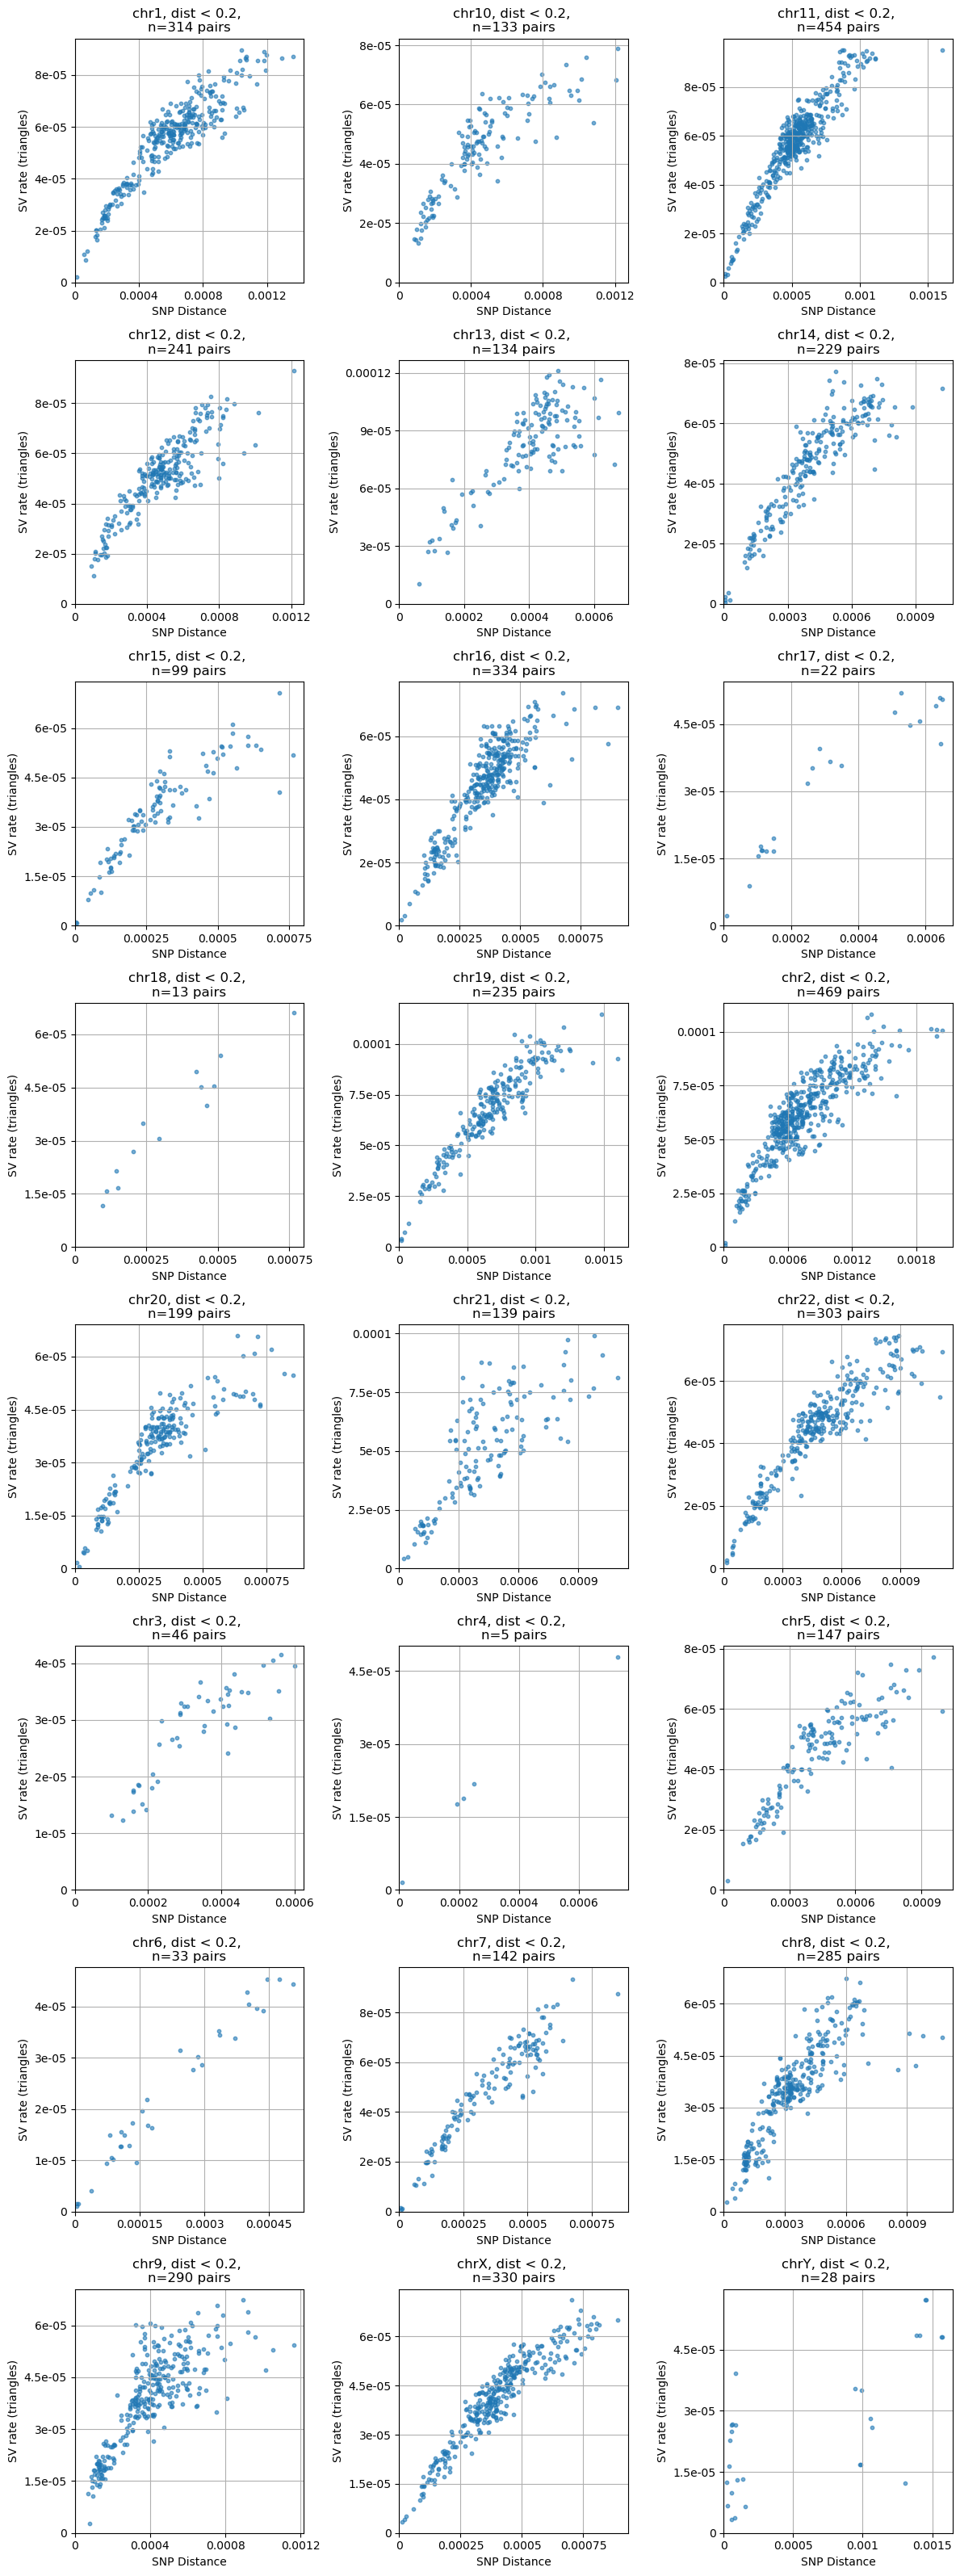

In [105]:
### Plot SV triangle rate vs SNP distance rate 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

# Step 1: filter the dataframe
filtered_df = SV_snp_rate_merged_df[
    (SV_snp_rate_merged_df["shape"] == "triangle") &
    (SV_snp_rate_merged_df["pairwise_dist"] < 0.2)
]

# Step 2: get sorted list of chromosomes
chromosomes = sorted(filtered_df["chr"].unique())
n_chrs = len(chromosomes)

# Step 3: create figure with 4 plots per row
n_cols = 3
n_rows = int(np.ceil(n_chrs / n_cols))
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(4*n_cols, 4*n_rows), squeeze=False)

# Step 4: plot each chromosome
for idx, chr_name in enumerate(chromosomes):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]

    chr_df = filtered_df[filtered_df["chr"] == chr_name]
    ax.scatter(chr_df["snp_dist"], chr_df["sv_rate"], alpha=0.6, s=10)
    ax.set_title(f"{chr_name}, dist < 0.2, \nn={len(chr_df)} pairs", fontsize=12)
    ax.set_xlabel("SNP Distance", fontsize=10)
    ax.set_ylabel("SV rate (triangles)", fontsize=10)
    ax.grid(True)

    # Force axes to start at 0
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)


    ax.xaxis.set_major_locator(MaxNLocator(nbins=4))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3g'))


# Step 5: remove unused subplots
for idx in range(n_chrs, n_rows*n_cols):
    row = idx // n_cols
    col = idx % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()


In [ ]:


# Force axes to start at 0
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

# Only 3 x-axis tick labels
x_max = chr_df["snp_dist"].max()
ax.set_xticks([0, x_max/2, x_max])


# Only 3 y-axis tick labels
y_max = chr_df["sv_rate"].max()
ax.set_yticks([0, y_max/2, y_max])

